In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns 
%matplotlib inline

from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

In [2]:
import warnings

warnings.filterwarnings('ignore')

In [3]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', 238)

In [4]:
sns.set_context("notebook")

## Data importations

In [5]:
# Delphine 
#df = pd.read_csv(r"/Users/delphinepaquiry/Downloads/Data.csv")

# Nathan 
df = pd.read_csv(r"C:\Users\Nathan\Desktop\Etude technique\Data.csv")

### Binary Columns

In [6]:
binary_columns= [
    "AnorexiedetypeboulemieActuel",
    "utilisationActuellaxatif",
    "utilisationActuelDiurétique",
    "AnorexiedetyperestrictifActuel",
    "AnorexiedetypeboulemiePasse",
    "utilisationPasselaxatif",
    "AnorexiedetyperestrictifPasse",
    "amenorheprimaire",
    "traitementcontraceptif",
    "Cyclesréguliers",
    "Signehyperandrogenie", 
    "Hyperactivite",
    "ActivitePhysiqueActuelPratriquee1 h/s",
    "ActivitePhysiquePassePratriquee1"    
]

In [7]:
df = df.drop(columns=binary_columns)

### Date Columns

In [8]:
colonnes_date =[
    'Dateexam',
    'DDN',
    'datePoidsleplusbas',
    'datePoidsleplushaut',
    'DatedebutTCA'
]

In [9]:
df['Dateexam'] = pd.to_datetime(df['Dateexam'])
df['datePoidsleplusbas'] = pd.to_datetime(df['datePoidsleplusbas'])
df['datePoidsleplushaut'] = pd.to_datetime(df['datePoidsleplushaut'])
df['DatedebutTCA'] = pd.to_datetime(df['DatedebutTCA'])

In [10]:
df['MoisPoidsBasExam'] = (df['Dateexam'].dt.year - df['datePoidsleplusbas'].dt.year) * 12 + (df['Dateexam'].dt.month - df['datePoidsleplusbas'].dt.month)

df['MoisPoidsHautExam'] = (df['Dateexam'].dt.year - df['datePoidsleplushaut'].dt.year) * 12 + (df['Dateexam'].dt.month - df['datePoidsleplushaut'].dt.month)

In [11]:
df = df.drop(columns=colonnes_date)

In [12]:
print(df.shape)

(366, 50)


### Create Zscore class

In [13]:
df=df.sort_values(['L1L4ZscoreSD'])

In [14]:
def map_target(value):
    if value <= -2:
        return 0  # pathologique
    else:
        return 1  # pas pathologique


df['Zscore_class'] = df['L1L4ZscoreSD'].apply(map_target)


In [15]:
df.reset_index(drop=True, inplace=True)

In [16]:
print(df)

           Age  PoidsT1  PoidsSD  TailleT1  TailleSD   IMC1  Poidsleplusbas  \
0    33.019178    42.55     -5.0     157.0      -1.0   9.29           22.60   
1    30.430137    42.55     -1.5     164.0       0.1  16.47           34.00   
2    28.682192    42.55     -4.0     171.0       1.5  10.88           30.00   
3    33.775342    42.55     -3.1     165.0       0.4  12.75           26.00   
4    25.293151    42.55     -1.4     157.0      -1.0  17.61           36.00   
5    28.468493    26.60     -5.0     157.0      -1.0  10.80           26.60   
6    30.290411    27.00     -4.4     167.0       0.8   9.68           27.00   
7    30.443836    37.50     -2.8     160.0      -0.5  14.66           29.00   
8    17.504110    42.55     -1.2     172.0       1.8  15.31           42.00   
9    36.208219    42.55     -1.4     173.0       1.9  15.04           39.50   
10   19.515068    42.80     -1.8     156.0      -1.2  17.59           42.50   
11   17.731507    31.90     -3.4     168.0       1.0

### Create our separate data

In [17]:
scaler = StandardScaler()

colonnes_a_standardiser = df.columns.difference(['L1L4ZscoreSD','DMOL1L4T1','Zscore_class'])

df_standardise = df.copy()  # Créez une copie du DataFrame pour ne pas modifier les données originales
df_standardise[colonnes_a_standardiser] = scaler.fit_transform(df[colonnes_a_standardiser])

# Rajouter la colonne exclue au DataFrame standardisé
df_standardise['L1L4ZscoreSD'] = df['L1L4ZscoreSD']

In [18]:
X= df.drop(columns=['L1L4ZscoreSD','DMOL1L4T1','Zscore_class'])
y = df['Zscore_class'] 

In [19]:
scaler = StandardScaler()

X = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [21]:
model = SVC(kernel='linear')

#### Cross validation

In [22]:
cv_scores = cross_val_score(model, X_train, y_train, cv=5)

print("Scores de validation croisée :", cv_scores)
print("Moyenne des scores de validation croisée :", np.mean(cv_scores))

Scores de validation croisée : [0.83050847 0.77966102 0.84482759 0.72413793 0.75862069]
Moyenne des scores de validation croisée : 0.787551139684395


#### Model Fit

In [23]:
# Définir les hyperparamètres à rechercher
param_grid = {
    'C': [0.1, 1, 10, 100],
    'gamma': [1, 0.1, 0.01, 0.001],
    'kernel': ['linear', 'rbf', 'poly']
}

# Instancier le modèle SVC
svc = SVC()

# Instancier GridSearchCV
grid_search = GridSearchCV(estimator=svc, param_grid=param_grid, cv=5, scoring='accuracy', verbose=2, n_jobs=-1)

# Effectuer la recherche sur grille
grid_search.fit(X_train, y_train)

# Afficher les meilleurs paramètres et le score
print("Meilleurs paramètres trouvés :", grid_search.best_params_)
print("Meilleur score d'accuracy :", grid_search.best_score_)


Fitting 5 folds for each of 48 candidates, totalling 240 fits
Meilleurs paramètres trouvés : {'C': 0.1, 'gamma': 0.1, 'kernel': 'poly'}
Meilleur score d'accuracy : 0.8080654587960258


In [24]:
best_params = {'C': 0.1, 'gamma': 0.1, 'kernel': 'poly'}

model = SVC(**best_params)

model.fit(X_train, y_train)

# Évaluation du modèle sur l'ensemble de test
test_score = model.score(X_test, y_test)
print("Score sur l'ensemble de test :", test_score)

Score sur l'ensemble de test : 0.7162162162162162


### Compréhension

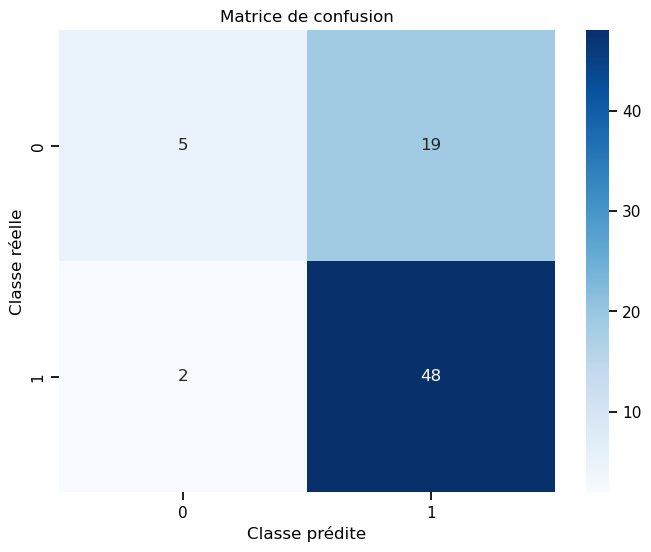

In [25]:
y_pred = model.predict(X_test)

conf_matrix = confusion_matrix(y_test, y_pred)

# Tracer la matrice de confusion
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, cmap="Blues", fmt="d")
plt.xlabel('Classe prédite')
plt.ylabel('Classe réelle')
plt.title('Matrice de confusion')
plt.show()

In [26]:
# Faire des prédictions sur l'ensemble de test
y_pred = model.predict(X_test)

# Créer un DataFrame pour stocker les prédictions incorrectes
misclassified = pd.DataFrame({'GrasTotal': X_test['GrasTotal'], 
                              'Predicted_Zscore_class': y_pred, 
                              'True_Zscore_class': y_test})

# Filtrer les prédictions incorrectes
misclassified = misclassified[misclassified['Predicted_Zscore_class'] != misclassified['True_Zscore_class']]

# Afficher le DataFrame misclassified
print(misclassified)

     GrasTotal  Predicted_Zscore_class  True_Zscore_class
33    0.132822                       1                  0
15    0.324330                       1                  0
57   -0.481403                       1                  0
76    0.552746                       1                  0
39    0.369262                       1                  0
55    0.711390                       1                  0
9    -0.157922                       1                  0
72    0.712834                       1                  0
108  -0.206176                       0                  1
42    0.201745                       1                  0
63   -0.529785                       1                  0
22   -0.700255                       1                  0
109  -0.466848                       0                  1
90   -0.325006                       1                  0
56    0.064493                       1                  0
45   -0.759807                       1                  0
77   -0.624946

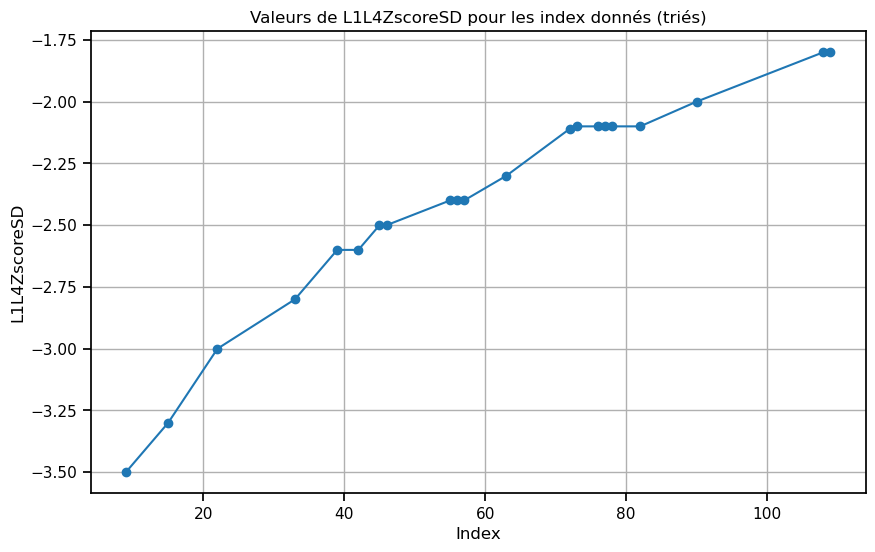

In [32]:
indices = misclassified.index.tolist()

indices_sorted = sorted(indices)

L1L4scoreSD_values = df.loc[indices_sorted, 'L1L4ZscoreSD']

# Tracer le graphique
plt.figure(figsize=(10, 6))
plt.plot(indices_sorted, L1L4scoreSD_values, marker='o', linestyle='-')
plt.xlabel('Index')
plt.ylabel('L1L4ZscoreSD')
plt.title('Valeurs de L1L4ZscoreSD pour les index donnés (triés)')
plt.grid(True)
plt.show()

### Features importantes

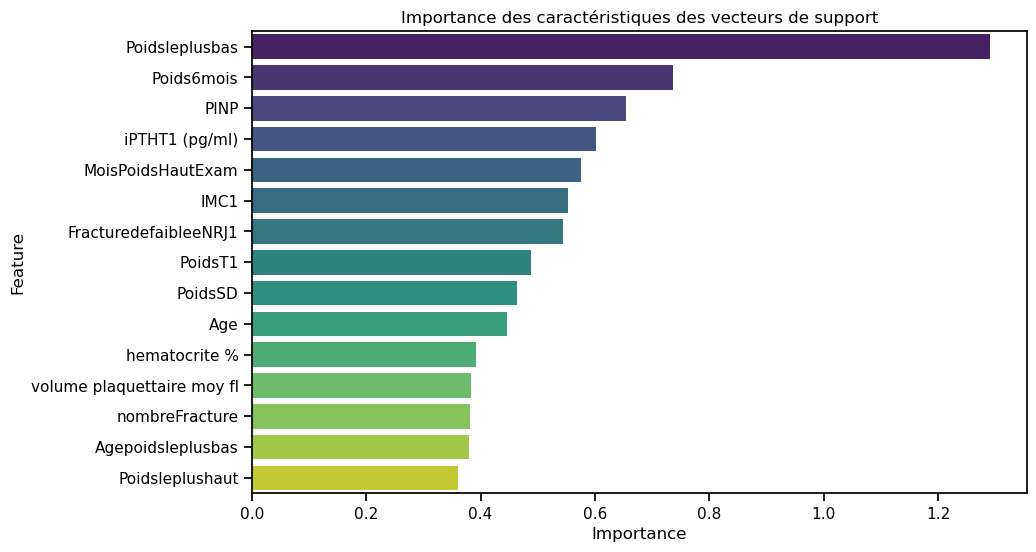

In [31]:
support_vector_coefficients = model.dual_coef_

# Calculer l'importance relative des caractéristiques en utilisant les coefficients associés aux vecteurs de support
feature_importance_support_vectors = np.abs(np.dot(support_vector_coefficients, model.support_vectors_))

# Créer un DataFrame pour l'importance des caractéristiques
importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importance_support_vectors[0]})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Afficher les 15 premières valeurs
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df.head(15), palette='viridis')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Importance des caractéristiques des vecteurs de support')
plt.show()
